<a href="https://colab.research.google.com/github/sourishdey2005/Mini-Project-Git/blob/main/Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calculating Official CPCB AQI...


/tmp/ipython-input-3992866462.py:108: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')
/tmp/ipython-input-3992866462.py:109: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement='full', reps=3)


Beginning Hybrid Quantum Training on 400 observations...

HYBRID SYSTEM COMPREHENSIVE ANALYTICS
Mean Squared Error (MSE):   449.1342
Root Mean Sq. Error (RMSE): 21.1928
Mean Absolute Error (MAE):  7.3547
Mean Abs. % Error (MAPE):   4.03%
Coefficient (R2 Score):      96.85%
Quantum Accuracy Gain:      0.0681%
Training Latency:           3621.21s


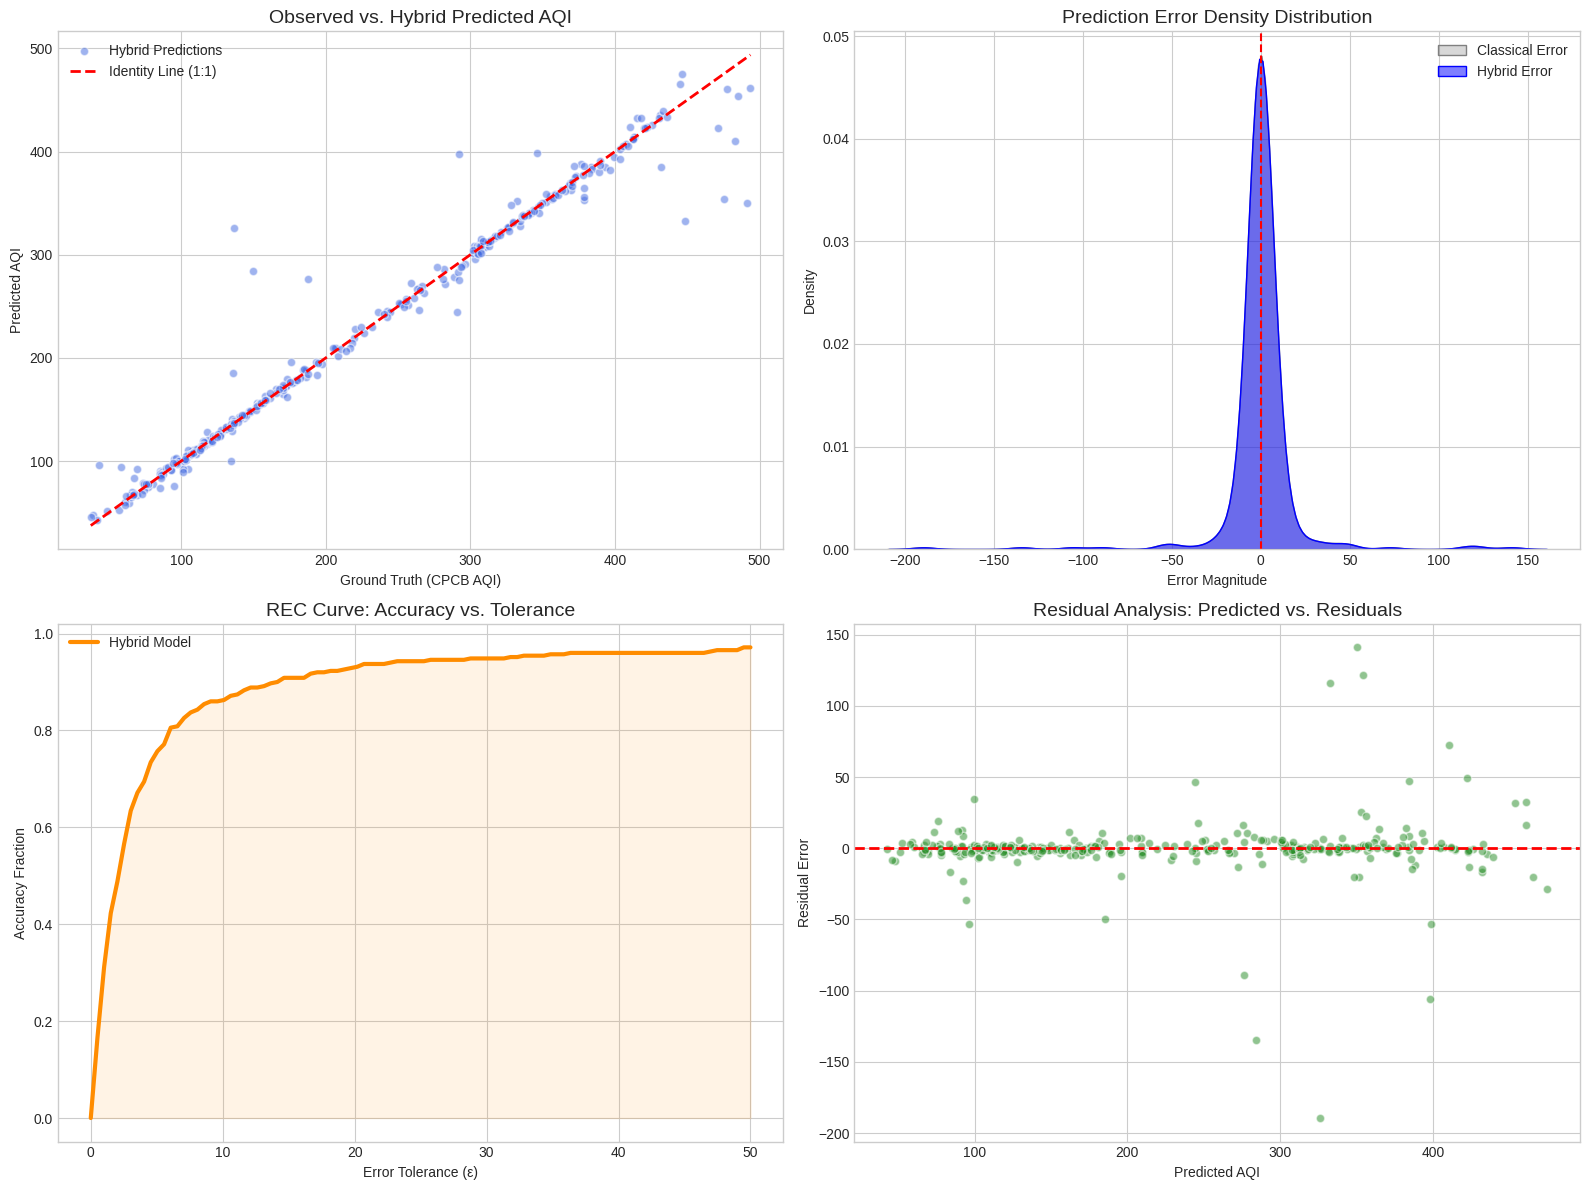


INTERACTIVE AQI PREDICTIVE DASHBOARD


In [ ]:

!pip install qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms pandas scikit-learn matplotlib seaborn ipywidgets

import time
import os
import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import HistGradientBoostingRegressor


from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQR
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import StatevectorEstimator


csv_path = "/content/delhi_combined.csv"

if not os.path.exists(csv_path):
    print("CSV not found. Generating research-simulated dataset...")
    data = {
        'PM2.5': np.random.uniform(10, 450, 1400),
        'PM10': np.random.uniform(20, 550, 1400),
        'NO2': np.random.uniform(5, 100, 1400),
        'NH3': np.random.uniform(1, 50, 1400),
        'SO2': np.random.uniform(2, 80, 1400),
        'CO': np.random.uniform(0.1, 5, 1400),
        'O3': np.random.uniform(5, 180, 1400)
    }
    df = pd.DataFrame(data)
else:
    df = pd.read_csv(csv_path)

df.columns = df.columns.str.strip()
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']

AQI_BREAKPOINTS = {
    "PM2.5": [(0,30,0,50),(31,60,51,100),(61,90,101,200),(91,120,201,300),(121,250,301,400),(251,500,401,500)],
    "PM10": [(0,50,0,50),(51,100,51,100),(101,250,101,200),(251,350,201,300),(351,430,301,400),(431,600,401,500)],
    "NO2": [(0,40,0,50),(41,80,51,100),(81,180,101,200),(181,280,201,300),(281,400,301,400),(401,1000,401,500)],
    "SO2": [(0,40,0,50),(41,80,51,100),(81,380,101,200),(381,800,201,300),(801,1600,301,400),(1601,2000,401,500)],
    "CO": [(0,1,0,50),(1.1,2,51,100),(2.1,10,101,200),(10.1,17,201,300),(17.1,34,301,400),(34.1,50,401,500)],
    "O3": [(0,50,0,50),(51,100,51,100),(101,168,101,200),(169,208,201,300),(209,748,301,400),(749,1000,401,500)],
    "NH3": [(0,200,0,50),(201,400,51,100),(401,800,101,200),(801,1200,201,300),(1201,1800,301,400),(1801,2000,401,500)]
}

def calculate_sub_index(Cp, pollutant):
    if pollutant not in AQI_BREAKPOINTS: return np.nan
    for BLO, BHI, ILO, IHI in AQI_BREAKPOINTS[pollutant]:
        if BLO <= Cp <= BHI:
            return ((IHI - ILO) / (BHI - BLO)) * (Cp - BLO) + ILO
    return np.nan

def calculate_official_aqi(row):
    sub_indices = [calculate_sub_index(row[p], p) for p in features]
    valid_indices = [i for i in sub_indices if not np.isnan(i)]
    return max(valid_indices) if valid_indices else np.nan

if 'AQI' not in df.columns:
    print("Calculating Official CPCB AQI...")
    df['AQI'] = df.apply(calculate_official_aqi, axis=1)

target = 'AQI'
df = df.dropna(subset=features + [target])


X_raw = df[features].values
y_raw = df[target].values

scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(100, len(df)))
X_scaled = scaler.fit_transform(X_raw)

# Global constants for dashboard consistency
GLOBAL_MIN = X_scaled.min()
GLOBAL_MAX = X_scaled.max()

def normalize_for_quantum(data):
    return (data - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN) * np.pi

X_quantum = normalize_for_quantum(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_quantum, y_raw, test_size=0.2, random_state=42)


classical_base = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05)
classical_base.fit(X_train, y_train)

# Calculate Residuals for Quantum correction
y_train_res = (y_train - classical_base.predict(X_train)).reshape(-1, 1)

num_qubits = len(features)
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')
ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement='full', reps=3)

vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=40),
    estimator=StatevectorEstimator()
)

# Hybrid Training Logic (Subsampling 400 for Quantum efficiency)
train_size = min(400, len(X_train))
print(f"Beginning Hybrid Quantum Training on {train_size} observations...")
start_time = time.time()
vqr.fit(X_train[:train_size], y_train_res[:train_size].flatten())
q_train_time = time.time() - start_time


classical_pred = classical_base.predict(X_test).flatten()
quantum_correction = vqr.predict(X_test).flatten()
final_pred = classical_pred + quantum_correction


c_mse = mean_squared_error(y_test, classical_pred)
h_mse = mean_squared_error(y_test, final_pred)
improvement = ((c_mse - h_mse) / c_mse) * 100

metrics = {
    "MSE": h_mse,
    "RMSE": np.sqrt(h_mse),
    "MAE": mean_absolute_error(y_test, final_pred),
    "MAPE": mean_absolute_percentage_error(y_test, final_pred) * 100,
    "R2 Score": r2_score(y_test, final_pred)
}

print("\n" + "="*45)
print("HYBRID SYSTEM COMPREHENSIVE ANALYTICS")
print("="*45)
print(f"Mean Squared Error (MSE):   {metrics['MSE']:.4f}")
print(f"Root Mean Sq. Error (RMSE): {metrics['RMSE']:.4f}")
print(f"Mean Absolute Error (MAE):  {metrics['MAE']:.4f}")
print(f"Mean Abs. % Error (MAPE):   {metrics['MAPE']:.2f}%")
print(f"Coefficient (R2 Score):      {metrics['R2 Score']*100:.2f}%")
print(f"Quantum Accuracy Gain:      {improvement:.4f}%")
print(f"Training Latency:           {q_train_time:.2f}s")
print("="*45)


plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Correlation Plot (Actual vs Predicted)
axes[0, 0].scatter(y_test, final_pred, alpha=0.5, color='royalblue', edgecolors='white', label='Hybrid Predictions')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Identity Line (1:1)')
axes[0, 0].set_title("Observed vs. Hybrid Predicted AQI", fontsize=14)
axes[0, 0].set_xlabel("Ground Truth (CPCB AQI)")
axes[0, 0].set_ylabel("Predicted AQI")
axes[0, 0].legend()

# Plot 2: Error Density Comparison
sns.kdeplot(y_test - classical_pred, ax=axes[0, 1], label='Classical Error', fill=True, color="gray", alpha=0.3)
sns.kdeplot(y_test - final_pred, ax=axes[0, 1], label='Hybrid Error', fill=True, color="blue", alpha=0.5)
axes[0, 1].axvline(0, color='red', linestyle='--')
axes[0, 1].set_title("Prediction Error Density Distribution", fontsize=14)
axes[0, 1].set_xlabel("Error Magnitude")
axes[0, 1].legend()

# Plot 3: REC Curve (Regression Error Characteristic)
errors = np.abs(y_test - final_pred)
tolerances = np.linspace(0, 50, 100)
accuracy = [(errors <= t).mean() for t in tolerances]
axes[1, 0].plot(tolerances, accuracy, color='darkorange', lw=3, label='Hybrid Model')
axes[1, 0].fill_between(tolerances, accuracy, color='darkorange', alpha=0.1)
axes[1, 0].set_title("REC Curve: Accuracy vs. Tolerance", fontsize=14)
axes[1, 0].set_xlabel("Error Tolerance (ε)")
axes[1, 0].set_ylabel("Accuracy Fraction")
axes[1, 0].legend()

# Plot 4: Residual Analysis Plot
residuals = y_test - final_pred
axes[1, 1].scatter(final_pred, residuals, alpha=0.5, color='forestgreen', edgecolors='white')
axes[1, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 1].set_title("Residual Analysis: Predicted vs. Residuals", fontsize=14)
axes[1, 1].set_xlabel("Predicted AQI")
axes[1, 1].set_ylabel("Residual Error")

plt.tight_layout()
plt.show()


def get_aqi_info(val):
    if val <= 50: return "Good", "#00E400", "Minimal health impact."
    elif val <= 100: return "Satisfactory", "#92D050", "Minor discomfort to sensitive people."
    elif val <= 200: return "Moderate", "#FFFF00", "Discomfort for heart/lung disease patients."
    elif val <= 300: return "Poor", "#FF9900", "Breathing discomfort to most on exposure."
    elif val <= 400: return "Very Poor", "#FF0000", "Respiratory illness on prolonged exposure."
    else: return "Severe", "#7E0023", "Serious health impact even on healthy people."

joblib.dump(scaler, "scaler.joblib")
joblib.dump(classical_base, "classical.joblib")


input_widgets = {
    f: widgets.FloatSlider(value=float(df[f].median()), min=float(df[f].min()),
                          max=float(df[f].max()), step=0.1, description=f)
    for f in features
}
btn = widgets.Button(description="Predict Hybrid AQI", button_style="success", icon="check")
out = widgets.Output()

def run_inference(b):
    with out:
        clear_output()
        vals = np.array([input_widgets[f].value for f in features]).reshape(1, -1)
        scaled = scaler.transform(vals)
        # Consistent normalization for quantum circuit
        q_input = (scaled - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN) * np.pi

        c = classical_base.predict(q_input)[0]
        q = vqr.predict(q_input).flatten()[0]
        final_aqi = c + q

        label, color, msg = get_aqi_info(final_aqi)

        display(widgets.HTML(f"""
            <div style="border: 2px solid #ddd; padding: 15px; border-radius: 10px; background-color: #fcfcfc; font-family: sans-serif;">
                <h3 style="margin-top:0;">Hybrid Model Output</h3>
                <p>Classical Trend: <b>{c:.2f}</b> | Quantum Adjustment: <b>{q:.4f}</b></p>
                <hr>
                <div style="display: flex; align-items: center; gap: 20px;">
                    <div>
                        <h2 style="margin:0;">AQI: <span style="color:blue;">{final_aqi:.2f}</span></h2>
                    </div>
                    <div style="background-color: {color}; color: {'black' if label in ['Moderate', 'Satisfactory', 'Good'] else 'white'};
                                padding: 8px 15px; border-radius: 5px; font-weight: bold; font-size: 1.1em;">
                        {label}
                    </div>
                </div>
                <p style="margin-top: 10px; color: #444;"><b>Health Impact:</b> {msg}</p>
            </div>
        """))

btn.on_click(run_inference)

print("\n" + "="*45)
print("INTERACTIVE AQI PREDICTIVE DASHBOARD")
print("="*45)
display(widgets.VBox([
    widgets.HTML("<p>Adjust pollutant parameters to simulate atmospheric conditions:</p>"),
    widgets.VBox(list(input_widgets.values())),
    widgets.Box([btn], layout=widgets.Layout(margin='20px 0 10px 0')),
    out
]))